In [2]:
!wget http://bit.ly/3ZLyF82 -O CSS.css -q
    
from IPython.core.display import HTML
with open('./CSS.css', 'r') as file:
    custom_css = file.read()

HTML(custom_css)

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline


# 데이터 로드
data = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')

# 피처와 타겟 분리
X = data.drop('Class', axis=1)
y = data['Class']


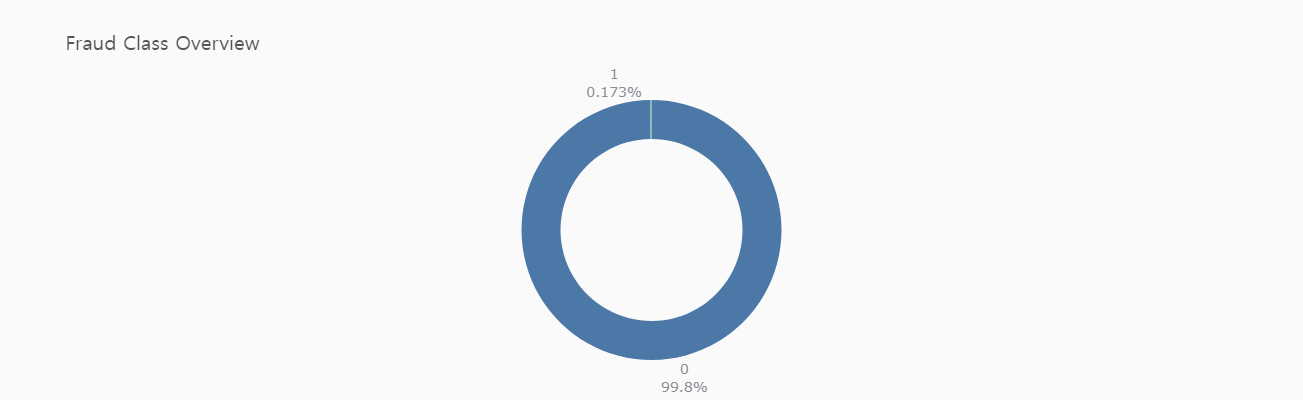

In [4]:
from plotly.offline import init_notebook_mode, iplot

init_notebook_mode(connected=True)  
fig2 = px.pie(data, names='Class', 
             height=400, width=600, 
             hole=0.7, 
             title='Fraud Class Overview',
                   color_discrete_sequence=['#4c78a8', '#72b7b2'])
fig2.update_traces(hovertemplate=None, textposition='outside', textinfo='percent+label', rotation=0)
fig2.update_layout(margin=dict(t=100, b=30, l=0, r=0), showlegend=False,
                        plot_bgcolor='#fafafa', paper_bgcolor='#fafafa',
                        title_font=dict(size=20, color='#555', family="Lato, sans-serif"),
                        font=dict(size=14, color='#8a8d93'),
                        hoverlabel=dict(bgcolor="#444", font_size=13, font_family="Lato, sans-serif"))
fig2.show()

In [5]:
# summary table function
def summary(df):
    print(f'data shape: {df.shape}')
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['#missing'] = df.isnull().sum().values * 100
    summ['%missing'] = df.isnull().sum().values / len(df)
    summ['#unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    summ['first value'] = df.loc[0].values
    summ['second value'] = df.loc[1].values
    summ['third value'] = df.loc[2].values
    
    return summ

In [6]:
summary(data)

data shape: (284807, 31)


,data type,#missing,%missing,#unique,min,max,first value,second value,third value
Time,float64,0,0.0,124592,0.000000,172792.000000,0.000000,0.000000,1.000000
V1,float64,0,0.0,275663,-56.407510,2.454930,-1.359807,1.191857,-1.358354
V2,float64,0,0.0,275663,-72.715728,22.057729,-0.072781,0.266151,-1.340163
V3,float64,0,0.0,275663,-48.325589,9.382558,2.536347,0.166480,1.773209
V4,float64,0,0.0,275663,-5.683171,16.875344,1.378155,0.448154,0.379780
V5,float64,0,0.0,275663,-113.743307,34.801666,-0.338321,0.060018,-0.503198
V6,float64,0,0.0,275663,-26.160506,73.301626,0.462388,-0.082361,1.800499
V7,float64,0,0.0,275663,-43.557242,120.589494,0.239599,-0.078803,0.791461
V8,float64,0,0.0,275663,-73.216718,20.007208,0.098698,0.085102,0.247676
V9,float64,0,0.0,275663,-13.434066,15.594995,0.363787,-0.255425,-1.514654


In [9]:
# 학습/테스트 데이터 분리 (3:7 비율)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 스케일링
scaler = StandardScaler()

# 스케일링 적용
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# StratifiedKFold 객체 생성
kf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

# XGBoost GPU 설정
gpu_params = {'tree_method': 'gpu_hist'}

# SMOTE 및 XGBoost 파이프라인 설정
pipeline = imbalanced_make_pipeline(SMOTE(random_state=42), XGBClassifier(n_jobs=-1, 
                                                                          random_state=42, 
                                                                          **gpu_params))


In [10]:
# 그리드 설정
param_grid = {
    'smote__sampling_strategy': [0.1, 0.25, 0.5, 0.75, 1.0],
    'xgbclassifier__max_depth': [3, 4, 5, 6],
    'xgbclassifier__subsample': [0.6, 0.8, 1.0]
}

# GridSearchCV 설정
grid = GridSearchCV(pipeline, param_grid=param_grid, cv=kf, scoring='roc_auc', 
                    return_train_score=True)

# 그리드서치 실행
grid.fit(X_train, y_train)

# 최적의 파라미터 출력
print('Best parameters:', grid.best_params_)

Best parameters: {'smote__sampling_strategy': 0.25, 'xgbclassifier__max_depth': 4, 'xgbclassifier__subsample': 0.6}


In [13]:
# 최적의 모델 저장
best_model = grid.best_estimator_

In [11]:
# 그리드서치 결과를 데이터프레임으로 변환
cv_results = pd.DataFrame(grid.cv_results_)

# 훈련 세트의 성능과 교차검증 세트의 성능을 비교
cv_results[['param_smote__sampling_strategy', 'param_xgbclassifier__max_depth', 
            'param_xgbclassifier__subsample', 'mean_train_score', 'mean_test_score']]


,param_smote__sampling_strategy,param_xgbclassifier__max_depth,param_xgbclassifier__subsample,mean_train_score,mean_test_score
0,0.1,3,0.6,0.999957,0.970916
1,0.1,3,0.8,0.999956,0.968853
2,0.1,3,1.0,0.999951,0.970733
3,0.1,4,0.6,0.999999,0.970082
4,0.1,4,0.8,0.999998,0.971800
5,0.1,4,1.0,0.999999,0.972055
6,0.1,5,0.6,1.000000,0.969245
7,0.1,5,0.8,1.000000,0.970841
8,0.1,5,1.0,1.000000,0.971494
9,0.1,6,0.6,1.000000,0.971474


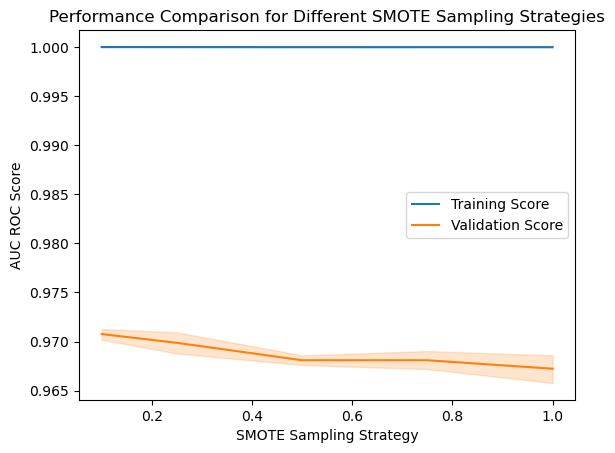

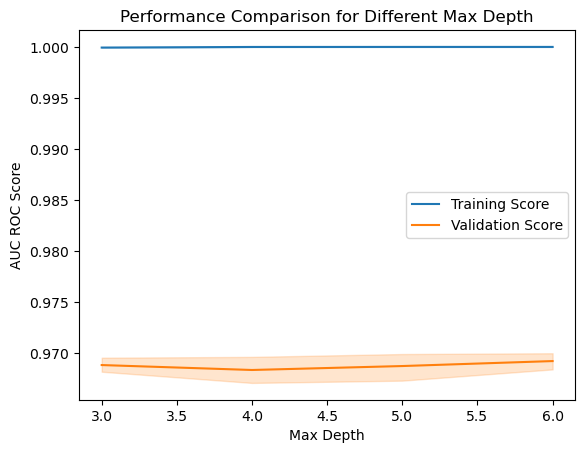

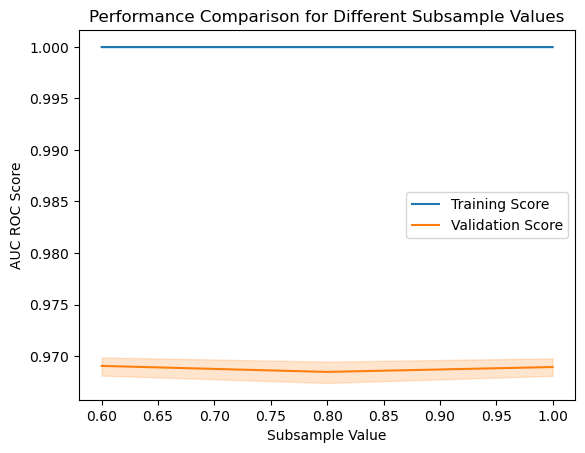

In [20]:
import seaborn as sns

# 샘플링 전략에 따른 성능 비교
sns.lineplot(data=cv_results, x='param_smote__sampling_strategy', y='mean_train_score', 
             label='Training Score')
sns.lineplot(data=cv_results, x='param_smote__sampling_strategy', y='mean_test_score', 
             label='Validation Score')
plt.title('Performance Comparison for Different SMOTE Sampling Strategies')
plt.ylabel('AUC ROC Score')
plt.xlabel('SMOTE Sampling Strategy')
plt.legend()
plt.show()

# 최대 깊이에 따른 성능 비교
sns.lineplot(data=cv_results, x='param_xgbclassifier__max_depth', y='mean_train_score', 
             label='Training Score')
sns.lineplot(data=cv_results, x='param_xgbclassifier__max_depth', y='mean_test_score', 
             label='Validation Score')
plt.title('Performance Comparison for Different Max Depth')
plt.ylabel('AUC ROC Score')
plt.xlabel('Max Depth')
plt.legend()
plt.show()

# 서브샘플에 따른 성능 비교
sns.lineplot(data=cv_results, x='param_xgbclassifier__subsample', y='mean_train_score', 
             label='Training Score')
sns.lineplot(data=cv_results, x='param_xgbclassifier__subsample', y='mean_test_score',
             label='Validation Score')
plt.title('Performance Comparison for Different Subsample Values')
plt.ylabel('AUC ROC Score')
plt.xlabel('Subsample Value')
plt.legend()
plt.show()


In [14]:
# 테스트 세트에 최적의 모델 적용 및 AUC-ROC 계산
y_test_pred = best_model.predict_proba(X_test)[:,1]
print('Final ROC AUC Score:', roc_auc_score(y_test, y_test_pred))


Final ROC AUC Score: 0.9901727773529376


<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">

<h3 align="left"><font color='#DEB887'>💡 결과 설명:</font></h3>


XGBoost와 같은 결정 트리 기반의 모델은 훈련 데이터에 대해 완벽하게 학습(overfitting)할 수 있기 때문에 훈련 점수가 1이 나올 수 있습니다. 이것은 모델이 훈련 데이터에 과적합될 가능성이 있음을 나타냅니다.

이런 현상은 특히 불균형 데이터셋에서 자주 발생합니다. SMOTE를 사용하여 소수 클래스를 오버샘플링하면, 새롭게 생성된 샘플은 원래 샘플과 매우 유사하기 때문에 모델이 쉽게 학습할 수 있습니다. 이로 인해 훈련 세트의 성능은 매우 높지만, 검증 세트에서의 성능은 상대적으로 낮아질 수 있습니다.

하지만, 교차 검증 점수가 0.96~0.98 사이로 나타났다면, 이는 모델이 검증 세트에서도 잘 일반화되고 있다는 좋은 신호입니다. 물론, 이 점수는 테스트 세트에서도 유지될지 확인해야 합니다. 교차 검증은 모델 성능의 안정성을 평가하는 좋은 방법이지만, 최종 테스트 세트에서의 성능이 가장 중요합니다.

> 실제 확률이 가장 높은 100건의 case 중 실제 fraud는 몇 건일까?

In [19]:
# 확률 상위 100개 중 실제 사기 건수
num_frauds = pred_df.iloc[:100]['true'].sum()
print(f"Top 100에서 실제 fraud는 {num_frauds}건")


Top 100에서 실제 fraud는 99건


> Bar graph로 시각화

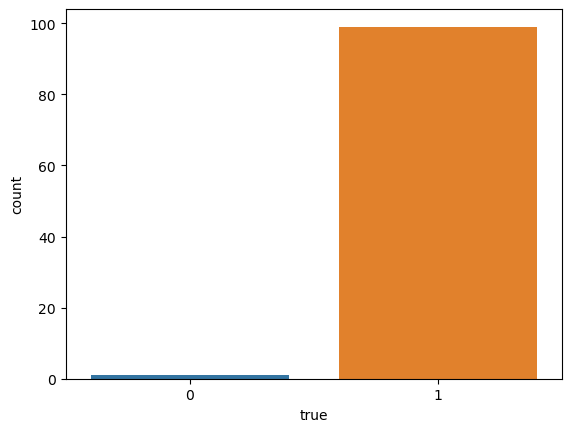

In [18]:
# 확률 상위 100개 중에 몇개가 진짜 사기인지 시각화
pred_df = pd.DataFrame({'true': y_test, 'pred': y_test_pred})
pred_df = pred_df.sort_values('pred', ascending=False)
sns.countplot(x='true', data=pred_df.iloc[:100])
plt.show()

> Q. 모델 배포 과정에서 신경써야하는 것은 어떤 것이 있는가?